Contained in this notebook is the individual analysis of one tcx file, and how to obtain the split paces, over a given distance (would need to pay for the MVP subscription to do this alternatively :-) ) 

In [5]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

tree = ET.parse('../data/8.03mi Run.tcx')

In [14]:
def parse_run_file(tcx,plots=True):
    """Parse the race file for useful split information, as well as potentially valuable plots. 
    
    
    Parameters
    ----------
    
    tcx : str
        The path to the tcx file to be parsed. 
        
        
    Returns
    -------
    
    
    """
    
    #import dependencies and plotting preferences. 
    
    import pandas as pd
    import numpy as np
    import xml.etree.ElementTree as ET
    import matplotlib.pyplot as plt
    plt.style.use('fivethirtyeight')
    %matplotlib inline

    #bring in tcx file.. note it is in an xml format, so this had to be searched a little before
    #I found the useful information. 
    tree = ET.parse(tcx)
    root = tree.getroot()
    #travel down the tree to get the distance measurements. 
    activity = root.getchildren()[0]
    try:
        measures = activity.getchildren()[0].getchildren()[1].getchildren()[4].getchildren()[1:]
    except:
        print("Are you sure you didn't do this workout on a treadmill? No tracking information available.")
        return 
    measures[1].getchildren()[0].text
    distances = []
    times = []
    for i,point in enumerate(measures):
        if len(point.getchildren()) == 4:
            dist = point.getchildren()[-1]
            distances.append(float(dist.text))
            times.append(point.getchildren()[0].text)
            
    #create a dataframe for this run, and generate a useful time series. 
    time_df = pd.DataFrame([])
    time_df['Time'] = times
    time_df['Time'] = time_df.Time.str.split('T',expand = True)[1]
    time_df['Time'] = time_df['Time'].str.split('+',expand=True)[0]
    time_df = time_df['Time'].str.split(':',expand=True)
    time_df = time_df.astype('float')
    time_df['Time Elapsed'] = time_df[0]*3600 + time_df[1]*60 + time_df[2]
    time_df['Time Elapsed'] = time_df['Time Elapsed'] -time_df['Time Elapsed'].values[0]
    del time_df[0],time_df[1],time_df[2]
    time_df['distance_meters'] = distances
    
    if plots:
        plt.figure()
        plt.title('Distance vs. Time')
        plt.xlabel('Time Elapsed (s)')
        plt.ylabel('Distance (m)')
        plt.plot(time_df['Time Elapsed'], time_df['distance_meters'])
    #create column for miles travelled. 
    time_df['distance_miles'] = time_df['distance_meters'] / 1609.344
    #round off values. 
    time_df['distance_miles'] = [("%.1f" % a) for a in time_df['distance_miles'].values]
    time_df['Time Elapsed'] = [("%.1f" % a) for a in time_df['Time Elapsed'].values]

    #now get pace information
    pace_data = pd.concat([g.tail(n=1) for _,g in time_df.groupby('distance_miles')])
    
    split_paces = []
    for i,_ in enumerate(pace_data['Time Elapsed'].values):
        if i < (len(pace_data)-1):
            time_elapsed = (float(pace_data['Time Elapsed'].values[i+1])
                            - float(pace_data
                                    ['Time Elapsed'].values[i]))
                
            sec_per_mile = 10 * time_elapsed
            min_per_mile = sec_per_mile/60
            split_paces.append(min_per_mile)
        else:
            split_paces.append(None)
    
    pace_data['min per mile split'] = split_paces 
    pace_data['rolling_mean_splits'] = pace_data['min per mile split'].rolling(window=5).mean()

    if plots: 
        plt.figure()
        plt.title('Split Pace vs. Time Elapsed')
        plt.xlabel('Time Elapsed (s)')
        plt.ylabel('Pace (min/mi)')
        plt.ylim((20,0))
        plt.plot(pace_data['Time Elapsed'],pace_data['min per mile split'],label='.1 mile splits')
        plt.plot(pace_data['Time Elapsed'],pace_data['rolling_mean_splits'],label='.5 mile avg') #half mile rolling mean. 
        plt.legend()

    return pace_data


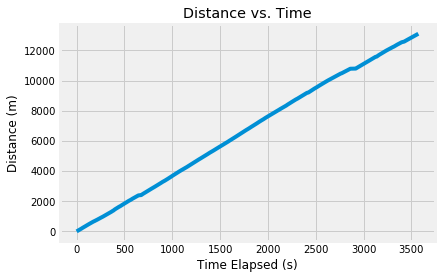

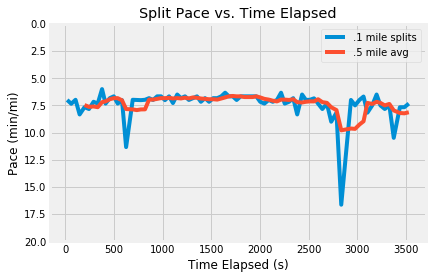

In [15]:
pace_df = parse_run_file('../data/Ran 8.15 mi on 02_02_19.tcx')

In [16]:
run_dataframes = []
os.chdir('../data/')
for filename in os.listdir():
    if filename.endswith(".tcx"): #or filename.endswith(".py"): 
        # print(os.path.join(directory, filename))
        run_dataframes.append(parse_run_file(filename))
        
    else:
        continue
    

Are you sure you didn't do this workout on a treadmill? No tracking information available.
Are you sure you didn't do this workout on a treadmill? No tracking information available.
Are you sure you didn't do this workout on a treadmill? No tracking information available.
Are you sure you didn't do this workout on a treadmill? No tracking information available.
Are you sure you didn't do this workout on a treadmill? No tracking information available.
Are you sure you didn't do this workout on a treadmill? No tracking information available.


In [25]:
cleaned = []
for df in run_dataframes:
    if type(df) != type(None):
        cleaned.append(df)
        
run_dataframes = cleaned
    

In [72]:
for run in run_dataframes:
    print("looking at a run> ")
    #run.reset_index(inplace=True)
    run.dropna(inplace=True)
    run.reset_index(inplace=True)

    worst_pace = run.loc[run['rolling_mean_splits'] == max(run['rolling_mean_splits'].values)] #this is not
    #one value!
   # print(worst_pace)
    for index, row in worst_pace.iterrows():
        part =  index/len(run)
        print("I fell off ", part*100, ' % into the run')

looking at a run> 
I fell off  71.1864406779661  % into the run
looking at a run> 
I fell off  80.51948051948052  % into the run
looking at a run> 
I fell off  94.73684210526315  % into the run
looking at a run> 
I fell off  9.090909090909092  % into the run
I fell off  18.181818181818183  % into the run
looking at a run> 
I fell off  90.78947368421053  % into the run


In [69]:
w

10.579999999999995

In [52]:
worst_pace.index[0]

3081

In [61]:
run.iloc[:]

Time Elapsed  distance_meters distance_miles  min per mile split  \
185         187.0       721.725403            0.4            7.000000   
227         229.0       884.947632            0.5            6.666667   
267         269.0      1043.468994            0.6            7.500000   
312         314.0      1206.419556            0.7            7.000000   
354         356.0      1365.355591            0.8            7.000000   
396         398.0      1526.030396            0.9            7.000000   
435         440.0      1687.734985            1.0            7.016667   
477         482.1      1848.568115            1.1            7.500000   
522         527.1      2010.351685            1.2            7.500000   
567         572.1      2171.878418            1.3            7.166667   
610         615.1      2330.194580            1.4            7.833333   
657         662.1      2493.438965            1.5            7.316667   
701         706.0      2652.796143            1.6            7.516667   
746         751.1      2813.739502            1.7            7.500000   
790         796.1      2975.428955            1.8            7.666667   
836         842.1      3134.701660            1.9            7.150000   
877         885.0      3298.140137            2.0            7.183333   
920         928.1      3456.801758            2.1            7.166667   
962         971.1      3619.807129            2.2            9.000000   
1009       1025.1      3778.205322            2.3            7.000000   
1051       1067.1      3939.597412            2.4            7.666667   
1097       1113.1      4100.688965            2.5            7.333333   
1140       1157.1      4262.289551            2.6            7.750000   
1184       1203.6      4424.493164            2.7            5.666667   
1218       1237.6      4583.818359            2.8            6.500000   
1257       1276.6      4743.232910            2.9            7.000000   
1297       1318.6      4905.183594            3.0            6.683333   
1337       1358.7      5067.237305            3.1            7.333333   
1381       1402.7      5228.966309            3.2            6.833333   
1422       1443.7      5391.193848            3.3            6.666667   
...           ...              ...            ...                 ...   
2120       2156.6      8126.379883            5.0            6.850000   
2161       2197.7      8287.649414            5.1            6.833333   
2202       2238.7      8448.935547            5.2            7.166667   
2245       2281.7      8608.618164            5.3            7.666667   
2291       2327.7      8769.201172            5.4            7.000000   
2333       2369.7      8928.033203            5.5           10.000000   
2371       2429.7      9092.209961            5.6            6.666667   
2411       2469.7      9250.932617            5.7            6.833333   
2452       2510.7      9410.692383            5.8            6.833333   
2493       2551.7      9572.806641            5.9            6.483333   
2531       2590.6      9732.855469            6.0            7.183333   
2572       2633.7      9895.520508            6.1            7.166667   
2615       2676.7     10056.977539            6.2            7.333333   
2658       2720.7     10218.990234            6.3            7.166667   
2701       2763.7     10376.520508            6.4            7.000000   
2743       2805.7     10537.963867            6.5            7.333333   
2786       2849.7     10699.669922            6.6            7.000000   
2828       2891.7     10859.702148            6.7            8.000000   
2876       2939.7     11022.808594            6.8            7.333333   
2920       2983.7     11183.267578            6.9            7.150000   
2962       3026.6     11345.682617            7.0            6.850000   
3003       3067.7     11505.123047            7.1           10.000000   
3036       3127.7     11665.526367            7.2            7.

In [ ]:
#travel down the tree to get the distance measurements. 
activity = root.getchildren()[0]
measures = activity.getchildren()[0].getchildren()[1].getchildren()[4].getchildren()[1:]
measures[1].getchildren()[0].text
distances = []
times = []
for i,point in enumerate(measures):
    if len(point.getchildren()) == 4:
        dist = point.getchildren()[-1]
        distances.append(float(dist.text))
        times.append(point.getchildren()[0].text)

In [ ]:
#create a dataframe for this run
time_df = pd.DataFrame([])
time_df['Time'] = times
time_df['Time'] = time_df.Time.str.split('T',expand = True)[1]
time_df['Time'] = time_df['Time'].str.split('+',expand=True)[0]
time_df = time_df['Time'].str.split(':',expand=True)
time_df = time_df.astype('float')
time_df['Time Elapsed'] = time_df[0]*3600 + time_df[1]*60 + time_df[2]
time_df['Time Elapsed'] = time_df['Time Elapsed'] -time_df['Time Elapsed'].values[0]
del time_df[0],time_df[1],time_df[2]
time_df['distance_meters'] = distances

In [ ]:
#create column for miles travelled. 
time_df['distance_miles'] = time_df['distance_meters'] / 1609.344

Now I would like to calculate my split pace for every .1 miles.



In [ ]:
time_df['distance_miles'] = [("%.1f" % a) for a in time_df['distance_miles'].values]
time_df['Time Elapsed'] = [("%.1f" % a) for a in time_df['Time Elapsed'].values]

In [ ]:
pace_data = pd.concat([g.tail(n=1) for _,g in time_df.groupby('distance_miles')])

In [ ]:
pace_data

In [ ]:
split_paces = []
for i,_ in enumerate(pace_data['Time Elapsed'].values):
    if i < (len(pace_data)-1):
        time_elapsed = (float(pace_data['Time Elapsed'].values[i+1])
                            - float(pace_data
                                    ['Time Elapsed'].values[i]))
        
        dist = .1
        
        sec_per_mile = 10 * time_elapsed
        min_per_mile = sec_per_mile/60
        split_paces.append(min_per_mile)
    else:
        split_paces.append(None)

In [ ]:
pace_data['min per mile split'] = split_paces 

In [ ]:
plt.title('Split Pace vs. Time Elapsed')
plt.ylim((20,0))
plt.plot(pace_data['Time Elapsed'],pace_data['min per mile split'])
plt.plot(pace_data['Time Elapsed'],pace_data['min per mile split'].rolling(window=5).mean()) #half mile rolling mean. 


In [ ]:
plt.ylim((20,0))

plt.plot(pace_data['Time Elapsed'],pace_data['min per mile split'].rolling(window=5).mean()) #half mile rolling mean. 



In [ ]:
for child in activity:
    print('   ',child.attrib)

In [ ]:
import tcxparser
tcx = tcxparser.TCXParser('8.03mi Run.tcx')

In [ ]:
txc

In [ ]:
#duration in seconds. 
tcx.time_values()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.plot(tcx.altitude_points())
tcx.distance

In [ ]:
3390 / 60

In [ ]:
#spot check passes. This is true!


tcx.activity.getchildren()

In [ ]:
root = tree.getroot()


In [ ]:
root.findtext()

In [ ]:
for child in tree:
    print(child.tag, child.attrib)

In [ ]:
root.tag

In [ ]:
root.getchildren()

In [ ]:
tree.findtext

In [ ]:
import untangle
obj = untangle.parse('8.03mi Run.tcx')

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'8.03mi Run.tcx'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.


In [ ]:
import os, csv
import lxml.etree as ET

# SET DIRECTORY
#cd = os.path.dirname(os.path.abspath(__file__))

# LOAD XML FILE
xmlfile = 'trackXML.xml'
dom = ET.parse(os.path.join(cd, xmlfile))

# DEFINING COLUMNS
columns = ['latitude', 'longitude', 'altitude', 'distance', 'watts']

# OPEN CSV FILE
with open(os.path.join(cd,'trackData.csv'), 'w') as m:
    writer = csv.writer(m)    
    writer.writerow(columns)

    nodexpath = dom.xpath('//Trackpoint')

    dataline = []   # FOR ONE-ROW CSV APPENDS
    datalines = []  # FOR FINAL OUTPUT 
    for j in range(1,len(nodexpath)+1):        
        dataline = []

        # LOCATE PATH OF EACH NODE VALUE
        latitudexpath = dom.xpath('//Trackpoint[{0}]/Position/LatitudeDegrees/text()'.format(j))
        dataline.append('') if latitudexpath == [] else dataline.append(latitudexpath[0])

        longitudexpath = dom.xpath('//Trackpoint[{0}]/Position/LongitudeDegrees/text()'.format(j))
        dataline.append('') if longitudexpath == [] else dataline.append(longitudexpath[0])

        altitudexpath = dom.xpath('//Trackpoint[{0}]/AltitudeMeters/text()'.format(j))
        dataline.append('') if altitudexpath == [] else dataline.append(altitudexpath[0])

        distancexpath = dom.xpath('//Trackpoint[{0}]/DistanceMeters/text()'.format(j))
        dataline.append('') if distancexpath == [] else dataline.append(distancexpath[0])

        wattsxpath = dom.xpath("//Trackpoint[{0}]/*[name()='Extensions']/*[name()='TPX']/*[name()='Watts']/text()".format(j))
        dataline.append('') if wattsxpath == [] else dataline.append(wattsxpath[0])

        datalines.append(dataline)
        writer.writerow(dataline)

print(datalines)